Small LR (0.001): final margin = -1.2588, test acc = 0.702
Medium LR (0.01): final margin = -0.8477, test acc = 0.678
Large LR (0.02): final margin = -0.7196, test acc = 0.614


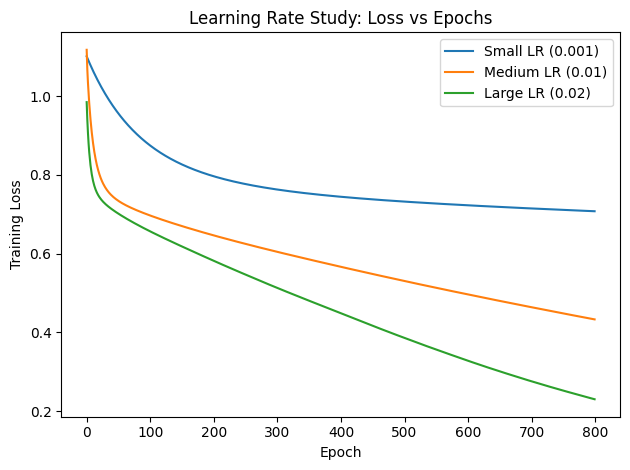

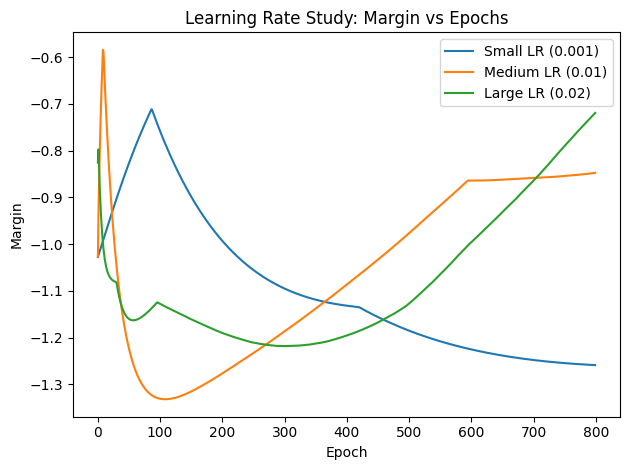

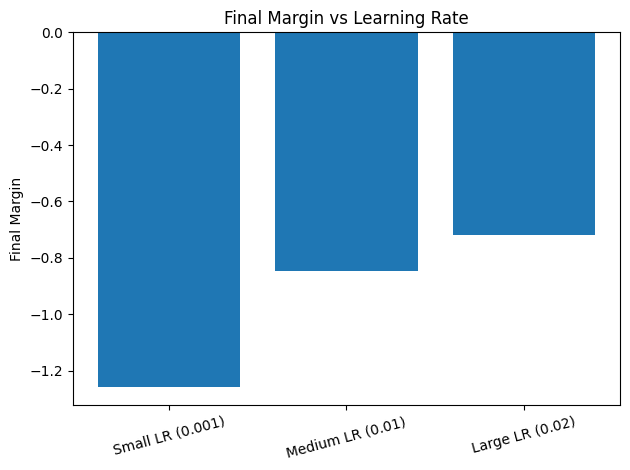

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def make_noisy_separable_gaussian_blobs(
    n_train=500,
    n_test=500,
    d=20,
    mean_sep=2.0,
    sigma=1.5,
    noise_rate=0.1,
    seed=42
):
    rng = np.random.default_rng(seed)

    # Means separated along first coordinate
    mu_pos = np.zeros(d); mu_pos[0] = +mean_sep / 2
    mu_neg = np.zeros(d); mu_neg[0] = -mean_sep / 2
    cov = (sigma ** 2) * np.eye(d)

    # Generate clean data
    X_train = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_train // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_train - n_train // 2),
    ])
    y_train = np.hstack([
        np.ones(n_train // 2),
        -np.ones(n_train - n_train // 2),
    ])

    X_test = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_test // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_test - n_test // 2),
    ])
    y_test = np.hstack([
        np.ones(n_test // 2),
        -np.ones(n_test - n_test // 2),
    ])

    # Shuffle
    perm_tr = rng.permutation(len(X_train))
    perm_te = rng.permutation(len(X_test))
    X_train, y_train = X_train[perm_tr], y_train[perm_tr]
    X_test, y_test = X_test[perm_te], y_test[perm_te]

    n_flip = int(noise_rate * n_train)
    flip_idx = rng.choice(n_train, size=n_flip, replace=False)
    y_train[flip_idx] *= -1

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )


X_train, y_train, X_test, y_test = make_noisy_separable_gaussian_blobs()

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

def train_model(lr, epochs=800):
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []
    margins = []

    for _ in range(epochs):
        optimizer.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        with torch.no_grad():
            margins.append(torch.min(y_train * model(X_train)).item())

    with torch.no_grad():
        test_acc = (torch.sign(model(X_test)) == y_test).float().mean().item()

    return losses, margins, test_acc


learning_rates = {
    "Small LR (0.001)": 0.001,
    "Medium LR (0.01)": 0.01,
    "Large LR (0.02)": 0.02,
}

results = {}

for label, lr in learning_rates.items():
    losses, margins, acc = train_model(lr)
    results[label] = {
        "losses": losses,
        "margins": margins,
        "final_margin": margins[-1],
        "test_acc": acc,
    }
    print(f"{label}: final margin = {margins[-1]:.4f}, test acc = {acc:.3f}")


plt.figure()
for label, res in results.items():
    plt.plot(res["losses"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Learning Rate Study: Loss vs Epochs")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for label, res in results.items():
    plt.plot(res["margins"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Margin")
plt.title("Learning Rate Study: Margin vs Epochs")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
labels = list(results.keys())
final_margins = [results[l]["final_margin"] for l in labels]
plt.bar(labels, final_margins)
plt.ylabel("Final Margin")
plt.title("Final Margin vs Learning Rate")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Full batch (100): final train acc=0.996, test acc=0.606, gap=+0.390, final margin=-0.1230, final loss=0.0670
Medium batch (20): final train acc=1.000, test acc=0.582, gap=+0.418, final margin=0.9950, final loss=0.0000
Small batch (5): final train acc=1.000, test acc=0.580, gap=+0.420, final margin=1.0000, final loss=0.0000


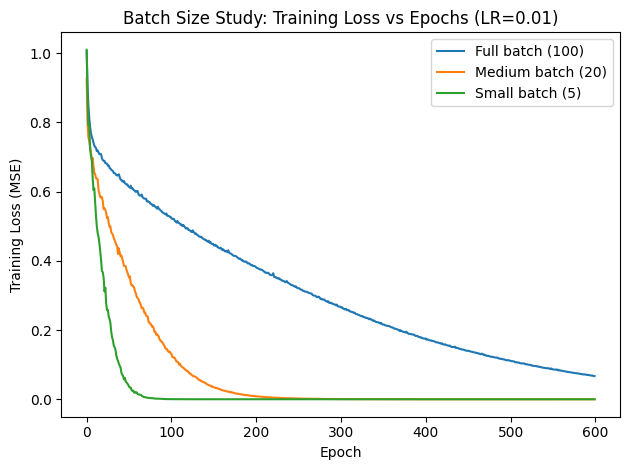

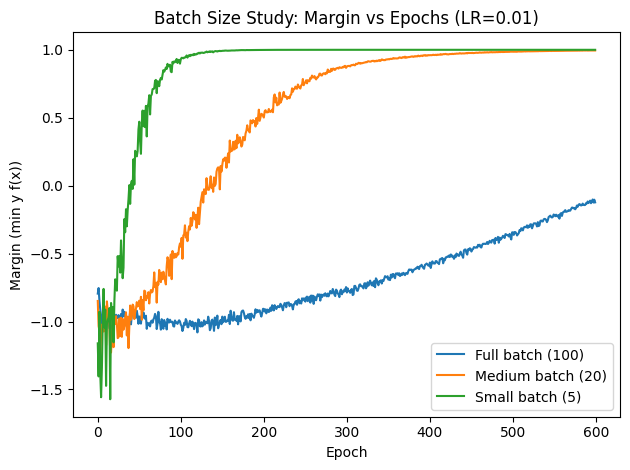

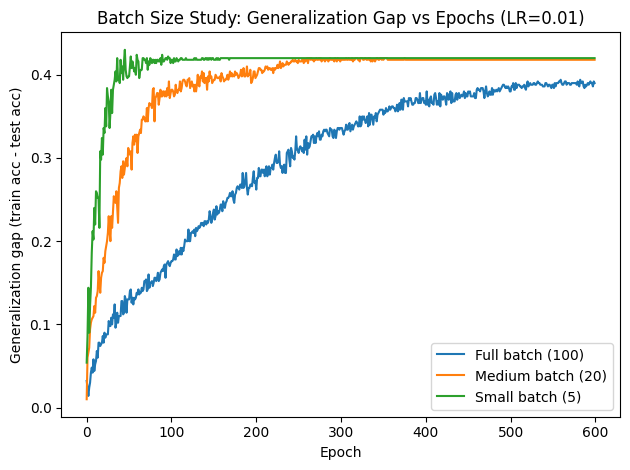

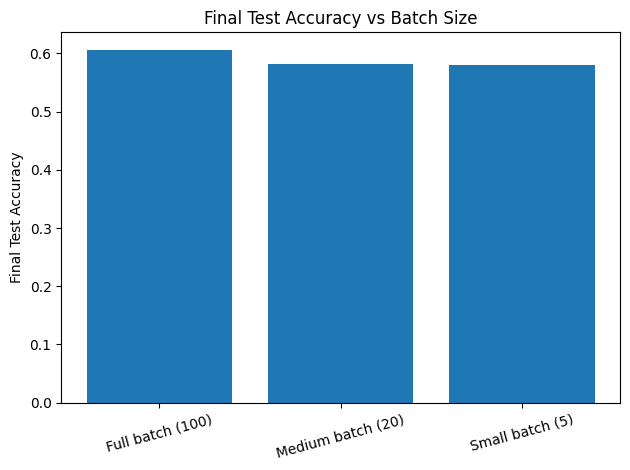

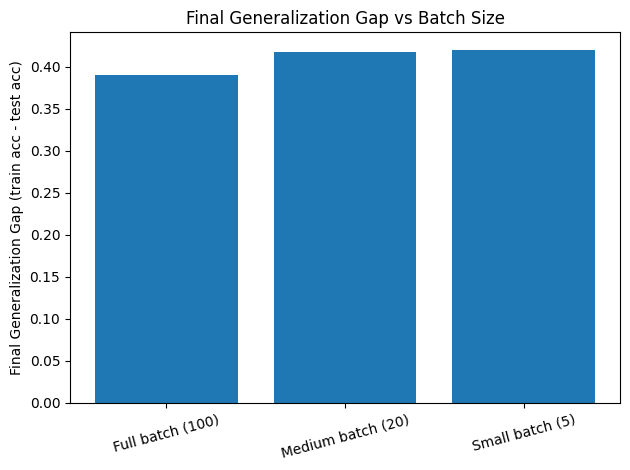

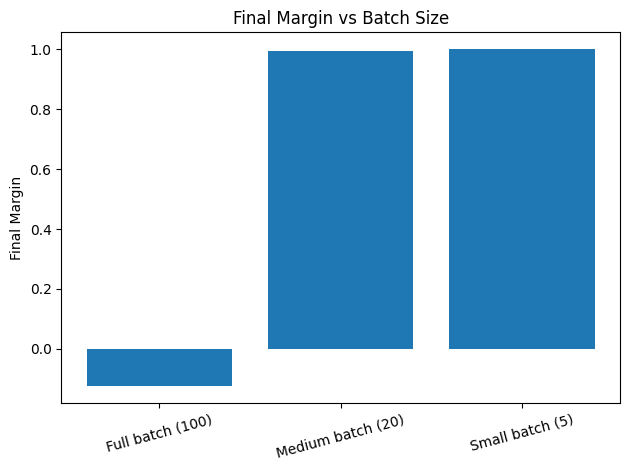

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



X_train, y_train, X_test, y_test = make_noisy_separable_gaussian_blobs()

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()


def train_with_batch_size(batch_size, lr=0.01, epochs=600, width=200, seed=0):
    torch.manual_seed(seed)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_ds = TensorDataset(X_train, y_train)
    loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

    train_losses = []
    train_margins = []
    train_accs = []
    test_accs = []
    gen_gaps = []

    for _ in range(epochs):
        # one epoch
        model.train()
        epoch_loss = 0.0
        n = 0
        for xb, yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(xb)
            n += len(xb)
        train_losses.append(epoch_loss / n)
        model.eval()
        with torch.no_grad():
            f_train = model(X_train)
            f_test = model(X_test)

            margin = torch.min(y_train * f_train).item()
            train_margins.append(margin)

            train_acc = (torch.sign(f_train) == y_train).float().mean().item()
            test_acc = (torch.sign(f_test) == y_test).float().mean().item()

            train_accs.append(train_acc)
            test_accs.append(test_acc)
            gen_gaps.append(train_acc - test_acc)

    return {
        "train_loss": train_losses,
        "margin": train_margins,
        "train_acc": train_accs,
        "test_acc": test_accs,
        "gen_gap": gen_gaps,
        "final_train_acc": train_accs[-1],
        "final_test_acc": test_accs[-1],
        "final_gap": gen_gaps[-1],
        "final_margin": train_margins[-1],
        "final_loss": train_losses[-1],
    }

lr = 0.01
epochs = 600
batch_sizes = {
    "Full batch (100)": 100,
    "Medium batch (20)": 20,
    "Small batch (5)": 5,
}

results = {}
for label, bs in batch_sizes.items():
    res = train_with_batch_size(bs, lr=lr, epochs=epochs, seed=123)
    results[label] = res
    print(f"{label}: final train acc={res['final_train_acc']:.3f}, test acc={res['final_test_acc']:.3f}, "
          f"gap={res['final_gap']:+.3f}, final margin={res['final_margin']:.4f}, final loss={res['final_loss']:.4f}")

plt.figure()
for label, res in results.items():
    plt.plot(res["train_loss"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title(f"Batch Size Study: Training Loss vs Epochs (LR={lr})")
plt.legend()
plt.tight_layout()
plt.show()
plt.figure()
for label, res in results.items():
    plt.plot(res["margin"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Margin (min y f(x))")
plt.title(f"Batch Size Study: Margin vs Epochs (LR={lr})")
plt.legend()
plt.tight_layout()
plt.show()
plt.figure()
for label, res in results.items():
    plt.plot(res["gen_gap"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Generalization gap (train acc - test acc)")
plt.title(f"Batch Size Study: Generalization Gap vs Epochs (LR={lr})")
plt.legend()
plt.tight_layout()
plt.show()
labels = list(results.keys())
final_test_accs = [results[l]["final_test_acc"] for l in labels]
final_gaps = [results[l]["final_gap"] for l in labels]
final_margins = [results[l]["final_margin"] for l in labels]

plt.figure()
plt.bar(labels, final_test_accs)
plt.ylabel("Final Test Accuracy")
plt.title("Final Test Accuracy vs Batch Size")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(labels, final_gaps)
plt.ylabel("Final Generalization Gap (train acc - test acc)")
plt.title("Final Generalization Gap vs Batch Size")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(labels, final_margins)
plt.ylabel("Final Margin")
plt.title("Final Margin vs Batch Size")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


EARLY STOP
 epoch=300, norm=8.177, margin=-1.037, test acc=0.678

LATE STOP
 epoch=1999, norm=8.775, margin=-0.632, test acc=0.616


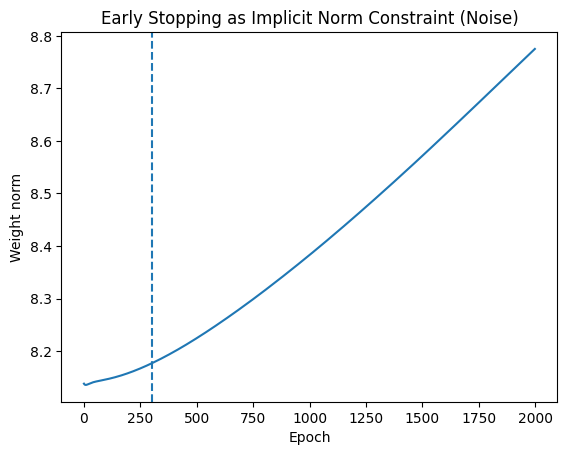

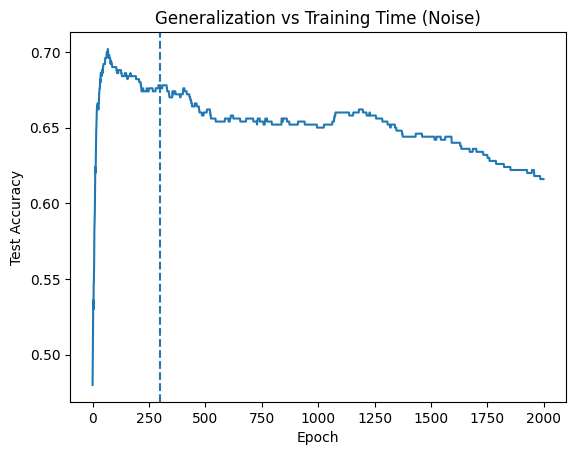

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

X_train, y_train, X_test, y_test = make_noisy_separable_gaussian_blobs()


class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

model = TwoLayerReLU(d=X_train.shape[1])
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

epochs = 2000
early_epoch = 300

norms, margins, test_accs = [], [], []

for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        norm = torch.sqrt(sum(torch.norm(p)**2 for p in model.parameters()))
        norms.append(norm.item())
        margins.append(torch.min(y_train * model(X_train)).item())
        acc = (torch.sign(model(X_test)) == y_test).float().mean().item()
        test_accs.append(acc)

print("EARLY STOP")
print(f" epoch={early_epoch}, norm={norms[early_epoch]:.3f}, "
      f"margin={margins[early_epoch]:.3f}, test acc={test_accs[early_epoch]:.3f}")

print("\nLATE STOP")
print(f" epoch={epochs-1}, norm={norms[-1]:.3f}, "
      f"margin={margins[-1]:.3f}, test acc={test_accs[-1]:.3f}")
plt.figure()
plt.plot(norms)
plt.axvline(early_epoch, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Weight norm")
plt.title("Early Stopping as Implicit Norm Constraint (Noise)")
plt.show()

plt.figure()
plt.plot(test_accs)
plt.axvline(early_epoch, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Generalization vs Training Time (Noise)")
plt.show()


In [ ]:
#Flatness Proxy for Learninf Rate

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


X_train, y_train, X_test, y_test = make_noisy_separable_gaussian_blobs()

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

criterion = nn.MSELoss()
def flatten_params(params):
    return torch.cat([p.contiguous().view(-1) for p in params])

def hessian_vector_product(loss, model, v):
    grads = torch.autograd.grad(
        loss, model.parameters(), create_graph=True, retain_graph=True
    )
    flat_grads = flatten_params(grads)
    Hv = torch.autograd.grad(flat_grads @ v, model.parameters(), retain_graph=True)
    return flatten_params(Hv)

def largest_hessian_eigenvalue(model, X, y, criterion, num_iters=15, tol=1e-6):
    model.zero_grad()
    loss = criterion(model(X), y)

    params = [p for p in model.parameters() if p.requires_grad]
    dim = sum(p.numel() for p in params)

    v = torch.randn(dim)
    v = v / (torch.norm(v) + 1e-12)

    prev_lambda = None
    for _ in range(num_iters):
        Hv = hessian_vector_product(loss, model, v)
        lambda_est = torch.dot(v, Hv)
        v = Hv / (torch.norm(Hv) + 1e-12)

        if prev_lambda is not None and torch.abs(lambda_est - prev_lambda) < tol:
            break
        prev_lambda = lambda_est

    return lambda_est.item()


def train_model(lr, epochs=800, seed=0):
    torch.manual_seed(seed)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    opt = optim.SGD(model.parameters(), lr=lr)

    for _ in range(epochs):
        opt.zero_grad()
        loss = criterion(model(X_train), y_train)
        loss.backward()
        opt.step()

    with torch.no_grad():
        train_acc = (torch.sign(model(X_train)) == y_train).float().mean().item()
        test_acc  = (torch.sign(model(X_test)) == y_test).float().mean().item()
        margin    = torch.min(y_train * model(X_train)).item()

    return model, train_acc, test_acc, margin

learning_rates = {
    "Small LR (0.001)": 0.001,
    "Medium LR (0.01)": 0.01,
    "Large LR (0.02)": 0.02,
}

print("LR\t\ttrain_acc\ttest_acc\tmargin\t\tlambda_max")
for name, lr in learning_rates.items():
    model, train_acc, test_acc, margin = train_model(lr, epochs=800, seed=123)
    lam = largest_hessian_eigenvalue(model, X_train, y_train, criterion, num_iters=15)

    print(f"{lr:.3g}\t\t{train_acc:.3f}\t\t{test_acc:.3f}\t\t{margin:.4f}\t\t{lam:.4e}")


LR		train_acc	test_acc	margin		lambda_max
0.001		0.762		0.690		-0.9958		5.3430e+01
0.01		0.874		0.634		-0.9883		5.5900e+01
0.02		0.964		0.620		-0.7471		5.9917e+01


In [ ]:
#Flatness Proxy for Batch Size
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train, y_train, X_test, y_test = make_noisy_separable_gaussian_blobs()

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

criterion = nn.MSELoss()

def flatten_params(params):
    return torch.cat([p.contiguous().view(-1) for p in params])

def hessian_vector_product(loss, model, v):
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True, retain_graph=True)
    flat_grads = flatten_params(grads)
    Hv = torch.autograd.grad(flat_grads @ v, model.parameters(), retain_graph=True)
    return flatten_params(Hv)

def largest_hessian_eigenvalue(model, X, y, criterion, num_iters=15, tol=1e-6):
    model.zero_grad()
    loss = criterion(model(X), y)

    params = [p for p in model.parameters() if p.requires_grad]
    dim = sum(p.numel() for p in params)

    v = torch.randn(dim)
    v = v / (torch.norm(v) + 1e-12)

    prev_lambda = None
    for _ in range(num_iters):
        Hv = hessian_vector_product(loss, model, v)
        lambda_est = torch.dot(v, Hv)
        v = Hv / (torch.norm(Hv) + 1e-12)

        if prev_lambda is not None and torch.abs(lambda_est - prev_lambda) < tol:
            break
        prev_lambda = lambda_est

    return lambda_est.item()

def train_model_batch(batch_size, lr=0.01, epochs=800, seed=0):
    torch.manual_seed(seed)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    opt = optim.SGD(model.parameters(), lr=lr)

    loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )

    for _ in range(epochs):
        for xb, yb in loader:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()

    with torch.no_grad():
        train_acc = (torch.sign(model(X_train)) == y_train).float().mean().item()
        test_acc  = (torch.sign(model(X_test)) == y_test).float().mean().item()
        margin    = torch.min(y_train * model(X_train)).item()

    return model, train_acc, test_acc, margin

batch_sizes = {
    "Full (500)": 500,
    "Medium (50)": 50,
    "Small (10)": 10,
}

lr = 0.01

print("Batch\t\ttrain_acc\ttest_acc\tmargin\t\tlambda_max")
for name, bs in batch_sizes.items():
    model, train_acc, test_acc, margin = train_model_batch(bs, lr=lr, epochs=800, seed=123)
    lam = largest_hessian_eigenvalue(model, X_train, y_train, criterion, num_iters=15)
    print(f"{name:10s}\t{train_acc:.3f}\t\t{test_acc:.3f}\t\t{margin:.4f}\t\t{lam:.4e}")


Batch		train_acc	test_acc	margin		lambda_max
Full (500)	0.874		0.634		-0.9883		5.5899e+01
Medium (50)	1.000		0.578		0.9030		7.6832e+01
Small (10)	1.000		0.580		1.0000		7.4489e+01


In [ ]:
#Flatness Proxy for early stopping
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

def make_separable_gaussian_blobs(
    n_train=500, n_test=500, d=20, mean_sep=2.0, sigma=1.5, seed=42
):
    rng = np.random.default_rng(seed)

    mu_pos = np.zeros(d); mu_pos[0] = +mean_sep / 2
    mu_neg = np.zeros(d); mu_neg[0] = -mean_sep / 2
    cov = sigma**2 * np.eye(d)

    X_train = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_train // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_train - n_train // 2),
    ])
    y_train = np.hstack([np.ones(n_train // 2), -np.ones(n_train - n_train // 2)])

    X_test = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_test // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_test - n_test // 2),
    ])
    y_test = np.hstack([np.ones(n_test // 2), -np.ones(n_test - n_test // 2)])

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )

X_train, y_train, X_test, y_test = make_separable_gaussian_blobs()

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

def flatten_params(params):
    return torch.cat([p.contiguous().view(-1) for p in params])

def hessian_vector_product(loss, model, v):
    grads = torch.autograd.grad(
        loss, model.parameters(), create_graph=True, retain_graph=True
    )
    flat_grads = flatten_params(grads)
    Hv = torch.autograd.grad(flat_grads @ v, model.parameters(), retain_graph=True)
    return flatten_params(Hv)

def largest_hessian_eigenvalue(model, X, y, criterion, num_iters=15, tol=1e-6):
    model.zero_grad()
    loss = criterion(model(X), y)

    params = [p for p in model.parameters() if p.requires_grad]
    dim = sum(p.numel() for p in params)

    v = torch.randn(dim)
    v = v / (torch.norm(v) + 1e-12)

    prev_lambda = None
    for _ in range(num_iters):
        Hv = hessian_vector_product(loss, model, v)
        lambda_est = torch.dot(v, Hv)
        v = Hv / (torch.norm(Hv) + 1e-12)

        if prev_lambda is not None and torch.abs(lambda_est - prev_lambda) < tol:
            break
        prev_lambda = lambda_est

    return lambda_est.item()

criterion = nn.MSELoss()
lr = 0.01
epochs = 2000
early_epoch = 300

torch.manual_seed(0)
model_late = TwoLayerReLU(d=X_train.shape[1], width=200)
optimizer = optim.SGD(model_late.parameters(), lr=lr)

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = criterion(model_late(X_train), y_train)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    train_acc_late = (torch.sign(model_late(X_train)) == y_train).float().mean().item()
    test_acc_late  = (torch.sign(model_late(X_test)) == y_test).float().mean().item()
    margin_late    = torch.min(y_train * model_late(X_train)).item()

lambda_late = largest_hessian_eigenvalue(
    model_late, X_train, y_train, criterion
)
torch.manual_seed(0)
model_early = TwoLayerReLU(d=X_train.shape[1], width=200)
optimizer = optim.SGD(model_early.parameters(), lr=lr)

for epoch in range(early_epoch):
    optimizer.zero_grad()
    loss = criterion(model_early(X_train), y_train)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    train_acc_early = (torch.sign(model_early(X_train)) == y_train).float().mean().item()
    test_acc_early  = (torch.sign(model_early(X_test)) == y_test).float().mean().item()
    margin_early    = torch.min(y_train * model_early(X_train)).item()

lambda_early = largest_hessian_eigenvalue(
    model_early, X_train, y_train, criterion
)
print("EARLY STOP")
print(f"train acc={train_acc_early:.3f}, test acc={test_acc_early:.3f}, "
      f"margin={margin_early:.4f}, lambda_max={lambda_early:.4e}")

print("\nLATE STOP")
print(f"train acc={train_acc_late:.3f}, test acc={test_acc_late:.3f}, "
      f"margin={margin_late:.4f}, lambda_max={lambda_late:.4e}")


EARLY STOP
train acc=0.842, test acc=0.646, margin=-0.8078, lambda_max=5.2474e+01

LATE STOP
train acc=0.992, test acc=0.620, margin=-0.0447, lambda_max=5.9357e+01
